In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [2]:
#data visualiztion
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
#preprocessing 
from sklearn.preprocessing import RobustScaler
from scipy.stats import norm

In [4]:
#model building
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import ElasticNet, Lasso
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.pipeline import make_pipeline

In [5]:
# metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [6]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
meal = pd.read_csv('meal_info.csv')
center = pd.read_csv('fulfilment_center_info.csv')

In [7]:
train.info

<bound method DataFrame.info of              id  week  center_id  meal_id  checkout_price  base_price  \
0       1379560     1         55     1885          136.83      152.29   
1       1466964     1         55     1993          136.83      135.83   
2       1346989     1         55     2539          134.86      135.86   
3       1338232     1         55     2139          339.50      437.53   
4       1448490     1         55     2631          243.50      242.50   
...         ...   ...        ...      ...             ...         ...   
456543  1271326   145         61     1543          484.09      484.09   
456544  1062036   145         61     2304          482.09      482.09   
456545  1110849   145         61     2664          237.68      321.07   
456546  1147725   145         61     2569          243.50      313.34   
456547  1361984   145         61     2490          292.03      290.03   

        emailer_for_promotion  homepage_featured  num_orders  
0                           

In [8]:
train.sample(7)

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders
39635,1382181,14,39,2631,205.64,256.08,0,0,40
434965,1485742,139,27,2490,292.03,290.03,0,0,364
136763,1025403,47,149,1878,280.33,282.33,0,1,69
53409,1400414,19,53,2631,253.23,252.23,0,0,55
43632,1191016,16,91,1971,324.04,324.04,0,0,27
38489,1123073,14,14,1803,169.78,168.78,0,0,229
97398,1431875,34,94,1962,640.23,641.23,0,0,81


In [9]:
train.dtypes

id                         int64
week                       int64
center_id                  int64
meal_id                    int64
checkout_price           float64
base_price               float64
emailer_for_promotion      int64
homepage_featured          int64
num_orders                 int64
dtype: object

In [10]:
train.isnull().sum()

id                       0
week                     0
center_id                0
meal_id                  0
checkout_price           0
base_price               0
emailer_for_promotion    0
homepage_featured        0
num_orders               0
dtype: int64

<AxesSubplot:xlabel='emailer_for_promotion', ylabel='count'>

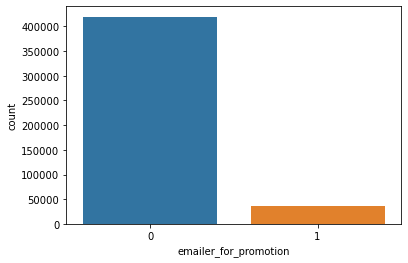

In [11]:
sns.countplot(data=train, x='emailer_for_promotion')

<AxesSubplot:xlabel='category', ylabel='count'>

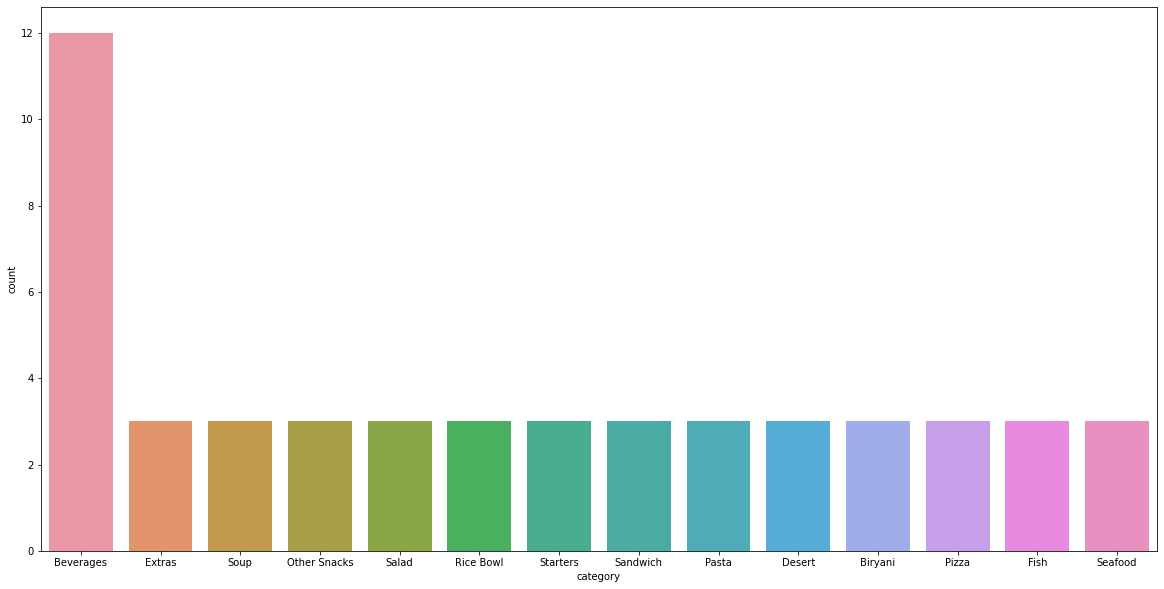

In [12]:
plt.figure(figsize=(20,10))
sns.countplot(data=meal, x='category')

(0.0, 10000.0)

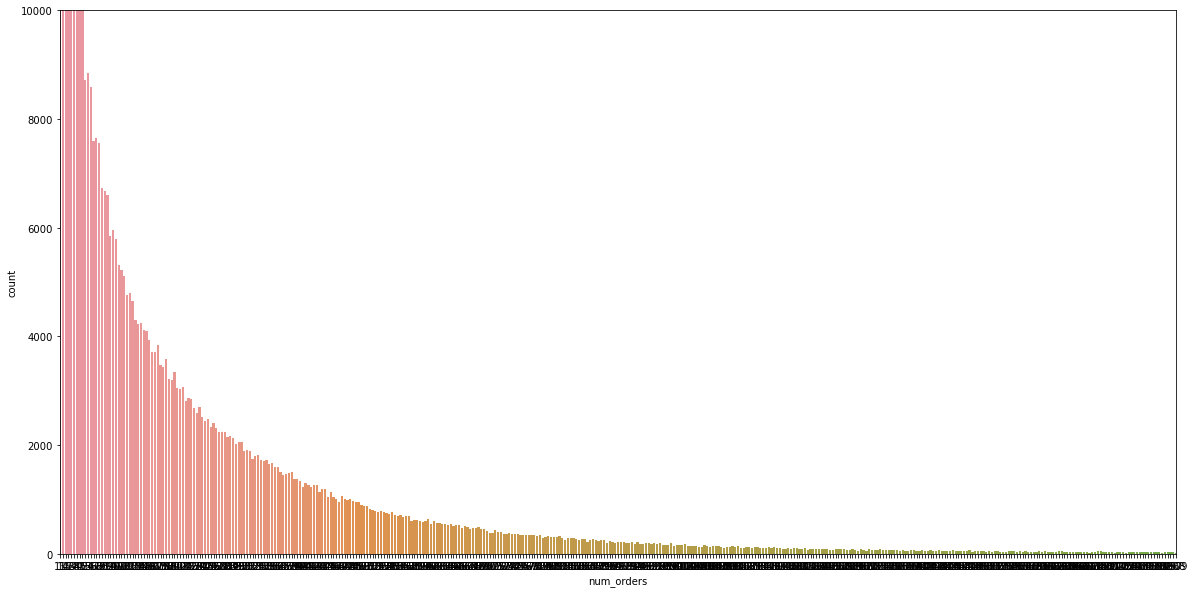

In [13]:
fig, ax = plt.subplots(figsize=(20, 10))

sns.countplot(train['num_orders'])
ax.set_xlim(0, 400)
ax.set_ylim(0, 10000)

(0.0, 5000.0)

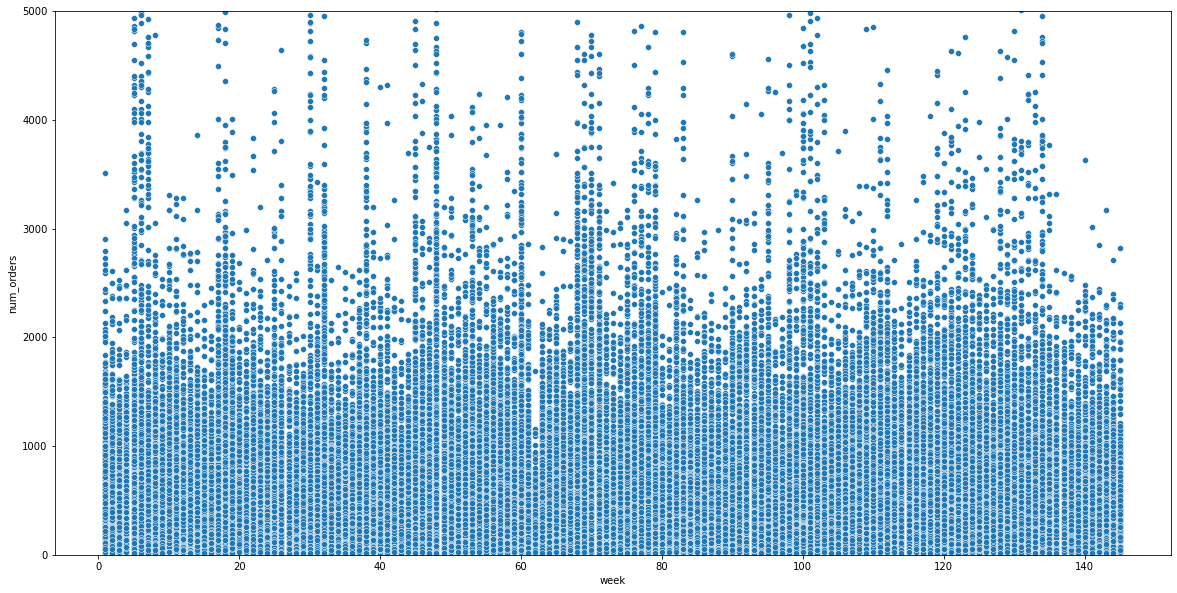

In [14]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.scatterplot(train['week'], train['num_orders'])
ax.set_ylim(0, 5000)

In [15]:
print(train['num_orders'].max())
print('\n')
print(train['num_orders'].min())
print('\n')
print(train['num_orders'].median())
print('\n')
print(train['num_orders'].mean())

24299


13


136.0


261.8727603669275


In [16]:
train = train.drop(train[train['num_orders'] > 3000].index)

In [17]:
train['num_orders'].skew()

3.097183042116124

In [18]:
train['num_orders'] = np.log1p(train['num_orders'])
train['num_orders'].skew()

-0.0633265004540242

Text(0.5, 1.0, 'num_orders distribution')

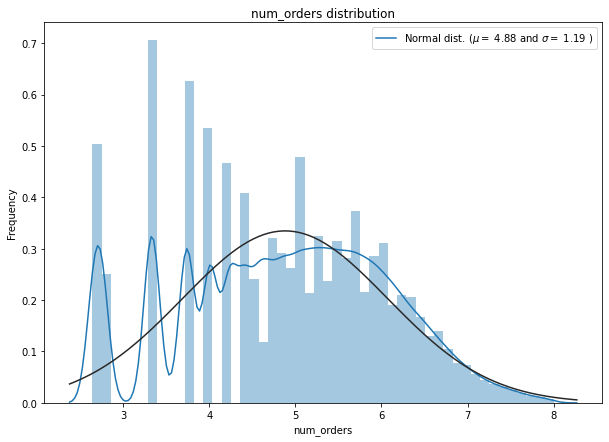

In [19]:
fig, ax = plt.subplots(figsize=(10, 7))

sns.distplot(train['num_orders'] , fit=norm)

(mu, sigma) = norm.fit(train['num_orders'])
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('num_orders distribution')

In [20]:
correlation_matrix = train.corr()
correlation_matrix['num_orders'].sort_values(ascending = False)

num_orders               1.000000
homepage_featured        0.238200
emailer_for_promotion    0.212833
meal_id                  0.030468
id                      -0.001501
week                    -0.006701
center_id               -0.055778
base_price              -0.330527
checkout_price          -0.387449
Name: num_orders, dtype: float64

Text(0.5, 1.0, 'Correlation Coefficient')

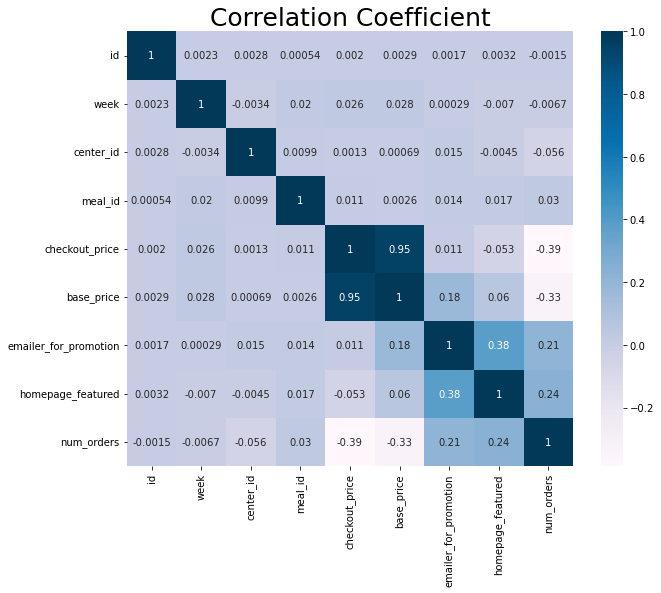

In [21]:
plt.figure(figsize=(10,8))
sns.heatmap(correlation_matrix, annot=True, cmap='PuBu')
plt.title('Correlation Coefficient',fontsize=25)

In [22]:
def rmse_CV(model):
    kf=KFold(n_splits=7, random_state=42, shuffle=True).get_n_splits(train.values)  #kf=7, only due to lack of shuffle of Cr_Val_Sc function
    rmse=np.sqrt(-cross_val_score(model, train.drop(['num_orders'], axis=1), train['num_orders'], scoring="neg_mean_squared_error", cv = kf))
    return rmse

In [23]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=7))

In [24]:
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.3, random_state=7))

In [25]:
GBoost = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=6, min_samples_split=2, 
                                  loss='huber', random_state =7)

In [26]:
model_xgb = XGBRegressor(colsample_bytree=0.46, gamma=0.046, 
                             learning_rate=0.1, max_depth=3, 
                             min_child_weight=2, n_estimators=100,
                             reg_alpha=0.4, reg_lambda=0.8,
                             subsample=0.5, random_state =7, nthread = -1)  #n_estimators (300, 500) best, lack of computing power

In [27]:
score = rmse_CV(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Lasso score: 1.0518 (0.0124)



In [28]:
score = rmse_CV(ENet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

ElasticNet score: 1.0518 (0.0124)



In [29]:
score = rmse_CV(GBoost)
print("\nGBoost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


GBoost score: 0.8155 (0.0218)



In [30]:
score = rmse_CV(model_xgb)
print("model_xgb score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

model_xgb score: 0.8062 (0.0224)



In [31]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)   

In [32]:
hybrid_models = AveragingModels(models = (lasso, ENet, GBoost, model_xgb))

score = rmse_CV(hybrid_models)

print(" Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

 Averaged base models score: 0.9040 (0.0128)



In [33]:
hybrid_models.fit(train.drop(['num_orders'], axis=1), train['num_orders'])

AveragingModels(models=(Pipeline(steps=[('robustscaler', RobustScaler()),
                                        ('lasso',
                                         Lasso(alpha=0.0005, random_state=7))]),
                        Pipeline(steps=[('robustscaler', RobustScaler()),
                                        ('elasticnet',
                                         ElasticNet(alpha=0.0005, l1_ratio=0.3,
                                                    random_state=7))]),
                        GradientBoostingRegressor(loss='huber', max_depth=4,
                                                  max_features='sqrt',
                                                  min_samples_leaf=6,
                                                  random_state=7),
                        XGBRegr...
                                     gamma=0.046, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_const

In [34]:
test['num_orders'] = np.expm1(hybrid_models.predict(test))

In [35]:
test.sample(7)

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders
19761,1347043,152,11,2826,378.33,379.33,0,0,199.990406
29820,1320986,155,186,1543,483.09,484.09,0,0,50.689082
15672,1204116,150,59,1902,447.23,447.23,0,0,59.864957
8192,1372061,148,153,1778,191.12,191.12,0,0,182.720479
28941,1424116,154,43,1109,276.51,275.51,0,0,242.319816
5823,1283499,147,143,2104,587.85,588.85,0,0,50.899971
13245,1182305,150,11,1248,95.12,163.93,0,0,218.773029


<AxesSubplot:xlabel='num_orders', ylabel='Density'>

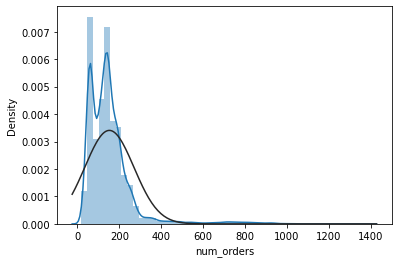

In [36]:
sns.distplot(test['num_orders'], fit=norm)

In [37]:
test.to_csv('test_predicted.csv',index=False)